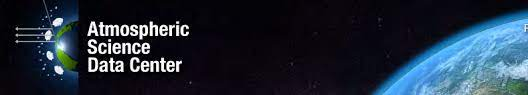


### How to Access DSCOVR_EPIC_L4_TO3 Data using OPeNDAP with Python3 and Calculate Daily Statistics from Instantaneous Data

* This instruction is based on Python3 and demonstrates how to remotely access the Deep Space Climate Observatory (DSCOVR, [1]) Earth Polychromatic Imaging Camera (EPIC, [2]) L4 instantaneous total ozone column data [3] files via OPeNDAP and analyze data such as resample instantaneous data into daily averages.

1. https://www.nesdis.noaa.gov/current-satellite-missions/currently-flying/dscovr-deep-space-climate-observatory
2. https://epic.gsfc.nasa.gov/about/epic
3. https://epic.gsfc.nasa.gov/science/products/o3
* Last update: Dec. 29, 2023

This Python3 example code demonstrates how to remotely access a dataset archived in ASDC using the Open-source Project for a Network Data Access Protocol (OPeNDAP) web service. We use the Modern-Era Retrospective analysis for Research and Applications, DSCOVR EPIC TrO3 in this example.




**Prerequisites**

- This example code is written in Python3 (v3.9.2) Jupyter Notebook and requires these libraries: earthaccess, cartopy.crs (0.18.0), calendar, time, platform (make sure all packages are up to date). In particular, here is the instruction on how to install [earthaccess](https://earthaccess.readthedocs.io/en/latest/) and [cartopy](https://scitools.org.uk/cartopy/docs/v0.15/installing.html).
- You can execute this example code in your Jupyter Notebook. This code has been tested with Jupyter Notebook v6.2.0 and v6.3.0 in Mac OS, Jupyter Notebook v6.1.4 in Windows OS. Or you can just run it in your Python 3 enviroment. This code has been tested in Python 3 in Mac, window and Linux OS.

**Procedure**:
1. Register Earthdata account and set up the credential environment

2. Execute the Python code below in your Jupyter Notebook step-by-step
- 2.1 Import the required Python modules or libraries. If any of the following import commands fail, check the local Python environment and install any missing packages.


## 1. Install necessary libraries

- 1.1 netCDF4

In [1]:
! pip3 install netCDF4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.5 MB/s eta 0:00:00


- 1.2 shapely, cartopy, and earthaccess

In [2]:
! pip3 install shapely==1.7.1 cartopy earthaccess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.2/383.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.0/169.0 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 28.5 MB/s eta 0:00:00
  Created wheel for shapely: filename=Shapely-1.7.1-cp310-cp310-linux_x86_64.whl size=997419 sha256=31f122bb8597d16f8754bc0e77b493988243dba9a35d11a8e8c37c3bc166e028
  Stored in directory: /root/.cache/pip/wheels/2e/fa/97/c85f587c35afcaf4a81c481741d36592518d1e50445572f0d4
Successfully built shapely
  Attempting uninstall: shapely
    Found existing installation: shapely 2.0.2
    Uninstalling shapely-2.0.2:
      Successfully uninstalled shapely-2.0.2
  Attempting unin

- 1.3 Import Authentication Libraries

In [3]:
import earthaccess
import os
import platform
from subprocess import Popen
import shutil

- 1.4 Create EDL files using the `earthaccess`

First, pass your Earthdata credentials to the `earthaccess` library to create the `.netrc` file:

In [4]:
auth = earthaccess.login(strategy="interactive", persist=True)

Enter your Earthdata Login username: alexrad71
Enter your Earthdata password: ··········
Persisting credentials to .netrc


- 1.5 Run the following code to generate the `.dodsrc` file, if it is not already present

In [5]:
homeDir = os.path.expanduser("~") + os.sep

with open(homeDir + '.dodsrc', 'w') as file:
    file.write('HTTP.COOKIEJAR={}.urs_cookies\n'.format(homeDir))
    file.write('HTTP.NETRC={}.netrc'.format(homeDir))
    file.close()

print('Saved .dodsrc to:', homeDir)

# Set appropriate permissions for Linux/macOS
if platform.system() != "Windows":
    Popen('chmod og-rw ~/.netrc', shell=True)
else:
    # Copy dodsrc to working directory in Windows
    shutil.copy2(homeDir + '.dodsrc', os.getcwd())
    print('Copied .dodsrc to:', os.getcwd())

Saved .dodsrc to: /root/


# **PAUSE HERE!**

### Restart your runtime by selecting "Runtime" -> "Restart Runtime"

Then, we will import the rest of the packages:

- 1.6 Then, import the rest of the packages:

In [2]:
# ----------------------
# Import Python modules
# ----------------------
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from calendar import monthrange
import time
import platform
print("platform.python_version() ", platform.python_version())
import requests
import sys

platform.python_version()  3.10.12


### 2. Accessing, exploring, and gridding data

- 2.1 Remotely access the instantaneous DSCOVR_EPIC_L2_TO3 files through OPeNDAP [URL](https://opendap.larc.nasa.gov/opendap/).

The user needs to choose year, month and range of days within the month, then the lists of available files are created for every day of interest.

Please note that the version of the collection may change. Current version is 1, see product_version  = '01'. In order to check for the current version, please search [EarthData](https://search.earthdata.nasa.gov/search?q=DSCOVR_EPIC_L4_TrO3).

The line of "%%time" at the beginning of each cell is used for estimating the running time for that cell.

In order to see the impact of Canadian wildfires of 2023, select first 10 days on June 2023.

In [4]:
%%time
# ---------------------------------
# Read data
# ---------------------------------

sat_name = 'DSCOVR'
sensor_name = 'EPIC'
level = 'L4'
product = 'TrO3'
product_version  = '01'

year = int(input('Enter year of interest, within the range 2015 - 2023: '))
month = int(input('Enter month of interest, in the range 1 - 12: '))
firstday = int(input('Enter the 1st day of interest: '))
lastday = int(input('Enter the last day of interest: '))

if lastday < firstday: sys.exit()

nd = lastday - firstday + 1
days = np.array(range(firstday, lastday + 1), dtype = int)
daily_granule_list = np.empty(nd, dtype = object)
for i in range(nd):
  daily_granule_list[i] = np.empty(0, dtype = str)

# OPeNDAP URL
url = 'https://opendap.larc.nasa.gov/opendap/{}/{}/{}_{}_{}/{:0>4d}/{:0>2d}/'.format(sat_name, sensor_name, level, product, product_version, year, month)
print(url)
response = requests.get(url)
page = response.text

strings = page.split('\n')
print(len(strings))
granule_list = []
for s in strings:
# searching for file links
  qq = s.find('"sameAs": "')
  if qq < 0: continue
  qh5 = s.find('.h5')
  if qh5 >= 0:
    qp = s.rfind('"')
    fname = s[qq + 11 : qp]
# now check whether day is in the range on interest
    day = int(s[qh5 - 11 : qh5 - 9])
    if day < firstday or day > lastday: continue
    granule_list.append(s[qq + 11 : qh5 + 3])

    for i in range(nd):
      if day == days[i]:
        daily_granule_list[i] = np.append(daily_granule_list[i], s[qq + 11 : qh5 + 3])
        break

for i in range(nd):
  print('day', i+1, ',', year, month, days[i], ',', len(daily_granule_list[i]),' granules:')
  for granule in daily_granule_list[i]:
    print(granule)

Enter year of interest, within the range 2015 - 2023: 2023
Enter month of interest, in the range 1 - 12: 6
Enter the 1st day of interest: 1
Enter the last day of interest: 12
https://opendap.larc.nasa.gov/opendap/DSCOVR/EPIC/L4_TrO3_01/2023/06/
36182
day 1 , 2023 6 1 , 21  granules:
https://opendap.larc.nasa.gov/opendap/hyrax/DSCOVR/EPIC/L4_TrO3_01/2023/06/DSCOVR_EPIC_L4_TrO3_01_20230601000831_03.h5
https://opendap.larc.nasa.gov/opendap/hyrax/DSCOVR/EPIC/L4_TrO3_01/2023/06/DSCOVR_EPIC_L4_TrO3_01_20230601011358_03.h5
https://opendap.larc.nasa.gov/opendap/hyrax/DSCOVR/EPIC/L4_TrO3_01/2023/06/DSCOVR_EPIC_L4_TrO3_01_20230601032452_03.h5
https://opendap.larc.nasa.gov/opendap/hyrax/DSCOVR/EPIC/L4_TrO3_01/2023/06/DSCOVR_EPIC_L4_TrO3_01_20230601043019_03.h5
https://opendap.larc.nasa.gov/opendap/hyrax/DSCOVR/EPIC/L4_TrO3_01/2023/06/DSCOVR_EPIC_L4_TrO3_01_20230601053546_03.h5
https://opendap.larc.nasa.gov/opendap/hyrax/DSCOVR/EPIC/L4_TrO3_01/2023/06/DSCOVR_EPIC_L4_TrO3_01_20230601064113_03.h5
ht

- 2.2 Exploring DSCOVR_EPIC_L4_TrO3_01 datasets and their dimensions.

In [7]:
ncf = nc.Dataset(granule_list[0], diskless=True, persist=False)

print('file ' + granule_list[0] + ' has been opened')
#print(ncf)
print(ncf.variables.keys())
print(ncf.dimensions.keys())
for d in ncf.dimensions.items():
  print(d)
for var in ncf.variables.items():
  print(var)

ncf.close()

file https://opendap.larc.nasa.gov/opendap/hyrax/DSCOVR/EPIC/L4_TrO3_01/2023/06/DSCOVR_EPIC_L4_TrO3_01_20230601000831_03.h5 has been opened
dict_keys(['AlgorithmFlag', 'CWF1', 'ErrorFlag', 'NadirLatitude', 'NadirLongitude', 'RadiativeCloudFraction', 'Reflectivity', 'SatelliteLookAngle', 'SolarZenithAngle', 'StratosphericColumnOzone', 'TotalColumnOzone', 'TropopausePressure', 'TroposphericColumnOzone', 'TroposphericColumnOzoneAdjusted', 'Latitude', 'Longitude', 'FakeDim2'])
dict_keys(['Latitude', 'FakeDim2', 'Longitude'])
('Latitude', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'Latitude', size = 180)
('FakeDim2', <class 'netCDF4._netCDF4.Dimension'>: name = 'FakeDim2', size = 1)
('Longitude', <class 'netCDF4._netCDF4.Dimension'>: name = 'Longitude', size = 360)
('AlgorithmFlag', <class 'netCDF4._netCDF4.Variable'>
float32 AlgorithmFlag(Latitude, Longitude)
    origname: AlgorithmFlag
    fullnamepath: /AlgorithmFlag
unlimited dimensions: Latitude
current shape = (180, 360)

- 2.3 Now reading tropospheric ozone column along with latitude/longitude position from the first granule available to explore the product more. Print the latitudes and longitudes as well as minimum value of total ozonre column. The latter will give us a hint on the array's 'de facto' fill value as fill value attribute is not set.

o3_var_name can be changed to "TotalColumnOzone" if total ozone column is of interest. However, user should use appropriate set of variables vmin, vmax, and cbar_ticks in section 3.

In [8]:
# ---------------------------------------------------
# Select your interested variable (e.g., otalColumnOzone)
# ---------------------------------------------------
o3_var_name = "TroposphericColumnOzone"
lat_var_name = "Latitude"
lon_var_name = "Longitude"

ncf = nc.Dataset(granule_list[0], diskless=True, persist=False)

o3 = np.array(ncf.variables[o3_var_name])
lat = np.array(ncf.variables[lat_var_name])
lon = np.array(ncf.variables[lon_var_name])

nlat = len(lat)
nlon = len(lon)

print(nlat, 'latitudes:')
print(lat)
print(nlon, 'longitudes')
print(lon)
print('minimum Tropospheric O3 column ', np.min(o3))

ncf.close()


180 latitudes:
[-89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 -81.5 -80.5 -79.5 -78.5
 -77.5 -76.5 -75.5 -74.5 -73.5 -72.5 -71.5 -70.5 -69.5 -68.5 -67.5 -66.5
 -65.5 -64.5 -63.5 -62.5 -61.5 -60.5 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5
 -53.5 -52.5 -51.5 -50.5 -49.5 -48.5 -47.5 -46.5 -45.5 -44.5 -43.5 -42.5
 -41.5 -40.5 -39.5 -38.5 -37.5 -36.5 -35.5 -34.5 -33.5 -32.5 -31.5 -30.5
 -29.5 -28.5 -27.5 -26.5 -25.5 -24.5 -23.5 -22.5 -21.5 -20.5 -19.5 -18.5
 -17.5 -16.5 -15.5 -14.5 -13.5 -12.5 -11.5 -10.5  -9.5  -8.5  -7.5  -6.5
  -5.5  -4.5  -3.5  -2.5  -1.5  -0.5   0.5   1.5   2.5   3.5   4.5   5.5
   6.5   7.5   8.5   9.5  10.5  11.5  12.5  13.5  14.5  15.5  16.5  17.5
  18.5  19.5  20.5  21.5  22.5  23.5  24.5  25.5  26.5  27.5  28.5  29.5
  30.5  31.5  32.5  33.5  34.5  35.5  36.5  37.5  38.5  39.5  40.5  41.5
  42.5  43.5  44.5  45.5  46.5  47.5  48.5  49.5  50.5  51.5  52.5  53.5
  54.5  55.5  56.5  57.5  58.5  59.5  60.5  61.5  62.5  63.5  64.5  65.5
  66.5  67.5  68.5  69.5  70.5  71.5

- 2.4 After printing out latitudes and longitudes of the grid box centers, we can select a geographic box for sub-setting. The code will automatically pick up the ranges of indices to read from OPENDAP server. Print out latitudes and longitudes of the gridboxes in the selected subset.

To see the impact of Canadian wildfires 2023 on the US North East, select
west_boundary -90, east_boundary -65, south_boundary 35, north_boundary 55.

In [9]:
print('please enter boundary of the region of interest')
west_boundary = float(input('please enter the westmost longitude '))
east_boundary = float(input('please enter the eastmost longitude '))
south_boundary = float(input('please enter the southmost latitude '))
north_boundary = float(input('please enter the northmost latitude '))
if west_boundary > east_boundary:
  print('west and east boundaries are incorrect, program terminated')
  sys.exit()
if south_boundary > north_boundary:
  print('south and north boundaries are incorrect, program terminated')
  sys.exit()

# range of longitude indices
lb = max(0, np.floor(west_boundary + 0.5).astype(int)+179)
rb = min(nlon - 1, np.floor(east_boundary + 0.5).astype(int)+180)
bb = max(0, np.floor(south_boundary + 0.5).astype(int)+89)
tb = min(nlat - 1, np.floor(north_boundary + 0.5).astype(int)+90)

print('west_boundary:', west_boundary, ', east_boundary:', east_boundary, '; gridboxes with longitudes from', lon[lb], 'to',  lon[rb], 'will be read')
print('south_boundary:', south_boundary, ', north_boundary:', north_boundary, '; gridboxes with longitudes from', lat[bb], 'to', lat[tb], 'will be read')

request_line = '?{}[{}:1:{}][{}:1:{}],{}[{}:1:{}],{}[{}:1:{}]'.format(o3_var_name, bb, tb, lb, rb, lat_var_name, bb, tb, lon_var_name, lb, rb)
print(request_line)

ncf = nc.Dataset(granule_list[0]+request_line, diskless=True, persist=False)
lat_sub = np.array(ncf.variables[lat_var_name])
lon_sub = np.array(ncf.variables[lon_var_name])

nlat_sub = len(lat_sub)
nlon_sub = len(lon_sub)

print(nlat_sub, 'latitudes:')
print(lat_sub)
print(nlon_sub, 'longitudes')
print(lon_sub)
ncf.close()
#-104 10 34 55

please enter boundary of the region of interest
please enter the westmost longitude -90
please enter the eastmost longitude -65
please enter the southmost latitude 35
please enter the northmost latitude 55
west_boundary: -90.0 , east_boundary: -65.0 ; gridboxes with longitudes from -90.5 to -64.5 will be read
south_boundary: 35.0 , north_boundary: 55.0 ; gridboxes with longitudes from 34.5 to 55.5 will be read
?TroposphericColumnOzone[124:1:145][89:1:115],Latitude[124:1:145],Longitude[89:1:115]
22 latitudes:
[34.5 35.5 36.5 37.5 38.5 39.5 40.5 41.5 42.5 43.5 44.5 45.5 46.5 47.5
 48.5 49.5 50.5 51.5 52.5 53.5 54.5 55.5]
27 longitudes
[-90.5 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 -81.5 -80.5 -79.5
 -78.5 -77.5 -76.5 -75.5 -74.5 -73.5 -72.5 -71.5 -70.5 -69.5 -68.5 -67.5
 -66.5 -65.5 -64.5]


- 2.5 Computing daily averages of total ozone column.

Code below performs gridding and averaging the data for every day of interest in two nested loops: the outer loop is by days, the inner loop is by granules within the day.

Please remeber, some days may have no granules due to some sensor problems.

In [12]:
%%time
# create output array
avg_O3 = np.empty([nd, nlat_sub, nlon_sub], dtype = float)
cnt_O3 = np.empty([nd, nlat_sub, nlon_sub], dtype = int)

avg_O3[:, :, :] = 0.
cnt_O3[:, :, :] = 0

for i in range(nd):
  for granule in daily_granule_list[i]:
    ncf = nc.Dataset(granule+request_line, diskless=True, persist=False)
    o3 = np.array(ncf.variables[o3_var_name])
    o3_loc = np.zeros_like(o3, dtype = float)
    cnt_loc = np.zeros_like(o3, dtype = int)

    mask = (o3 > 0.)

    o3_loc[mask] = o3[mask]
    cnt_loc[mask] = 1
    print(granule)
    avg_O3[i, :, :] = avg_O3[i, :, :] + o3_loc[:, :]
    cnt_O3[i, :, :] = cnt_O3[i, :, :] + cnt_loc[:, :]

    ncf.close()

mask_all = (cnt_O3 > 0)
avg_O3[mask_all] = avg_O3[mask_all]/cnt_O3[mask_all]

https://opendap.larc.nasa.gov/opendap/hyrax/DSCOVR/EPIC/L4_TrO3_01/2023/06/DSCOVR_EPIC_L4_TrO3_01_20230601000831_03.h5
https://opendap.larc.nasa.gov/opendap/hyrax/DSCOVR/EPIC/L4_TrO3_01/2023/06/DSCOVR_EPIC_L4_TrO3_01_20230601011358_03.h5
https://opendap.larc.nasa.gov/opendap/hyrax/DSCOVR/EPIC/L4_TrO3_01/2023/06/DSCOVR_EPIC_L4_TrO3_01_20230601032452_03.h5
https://opendap.larc.nasa.gov/opendap/hyrax/DSCOVR/EPIC/L4_TrO3_01/2023/06/DSCOVR_EPIC_L4_TrO3_01_20230601043019_03.h5
https://opendap.larc.nasa.gov/opendap/hyrax/DSCOVR/EPIC/L4_TrO3_01/2023/06/DSCOVR_EPIC_L4_TrO3_01_20230601053546_03.h5
https://opendap.larc.nasa.gov/opendap/hyrax/DSCOVR/EPIC/L4_TrO3_01/2023/06/DSCOVR_EPIC_L4_TrO3_01_20230601064113_03.h5
https://opendap.larc.nasa.gov/opendap/hyrax/DSCOVR/EPIC/L4_TrO3_01/2023/06/DSCOVR_EPIC_L4_TrO3_01_20230601074640_03.h5
https://opendap.larc.nasa.gov/opendap/hyrax/DSCOVR/EPIC/L4_TrO3_01/2023/06/DSCOVR_EPIC_L4_TrO3_01_20230601085208_03.h5
https://opendap.larc.nasa.gov/opendap/hyrax/DSCO

 - 3. Plotting maps of daily average O3 columns

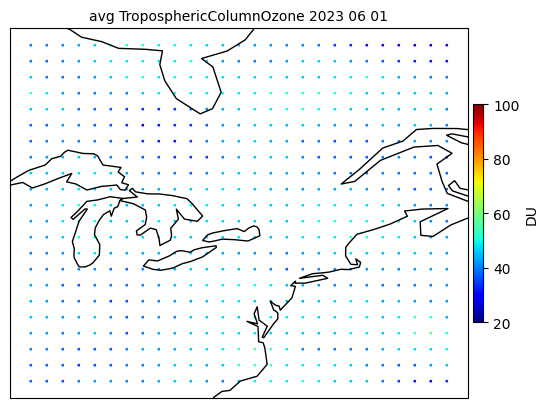

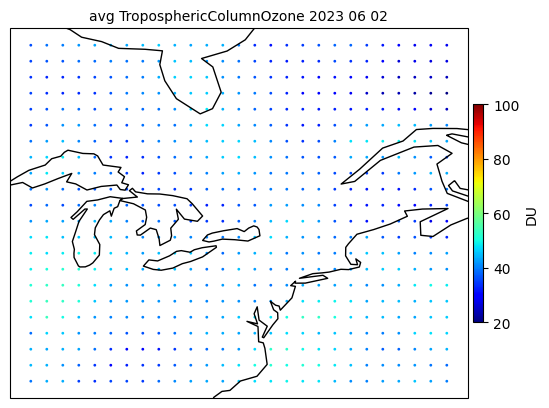

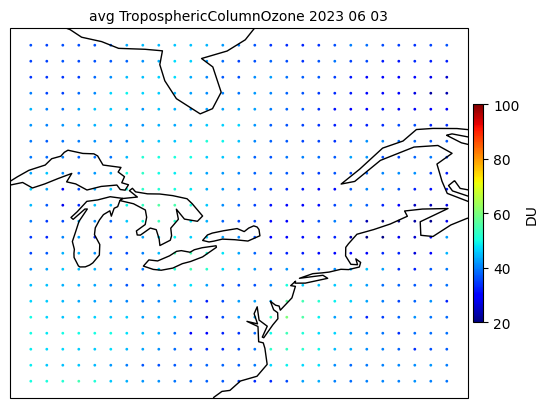

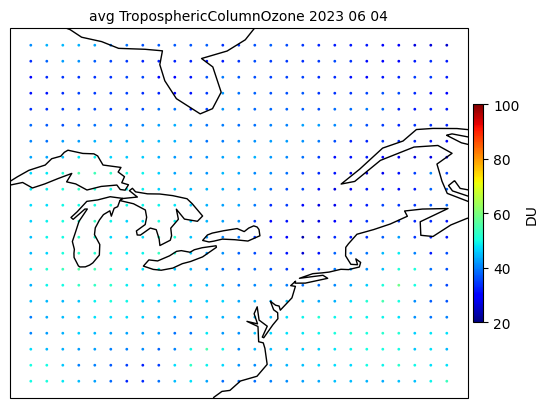

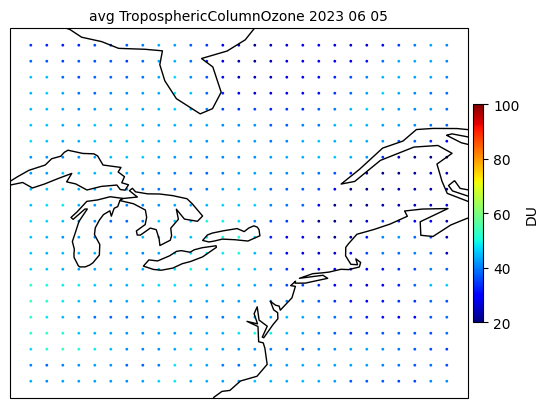

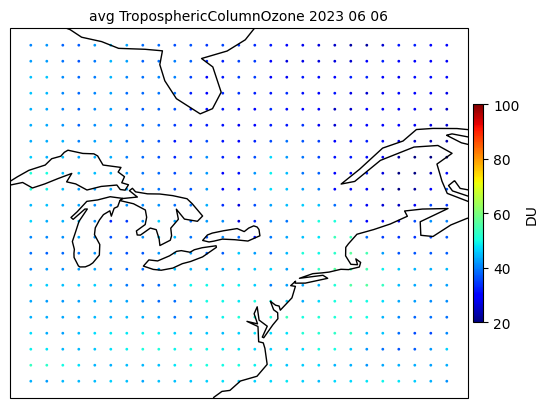

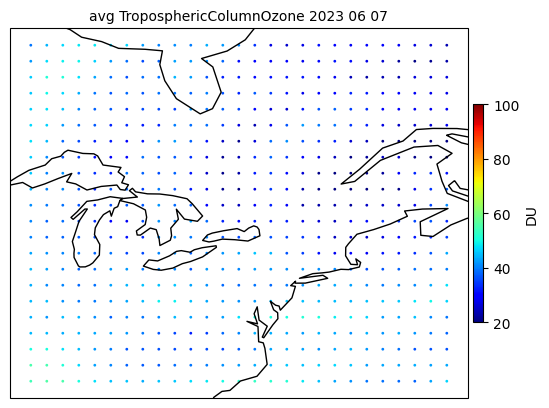

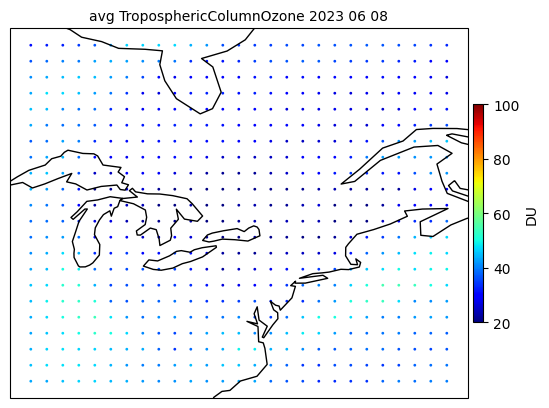

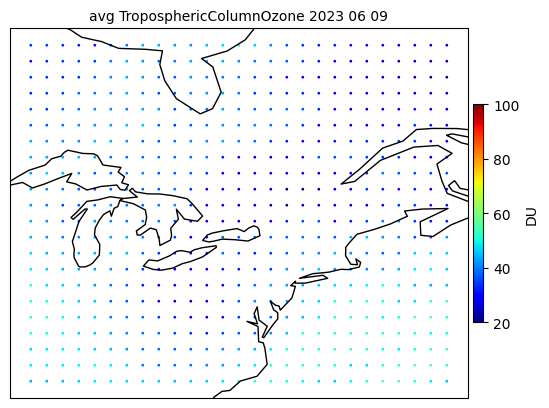

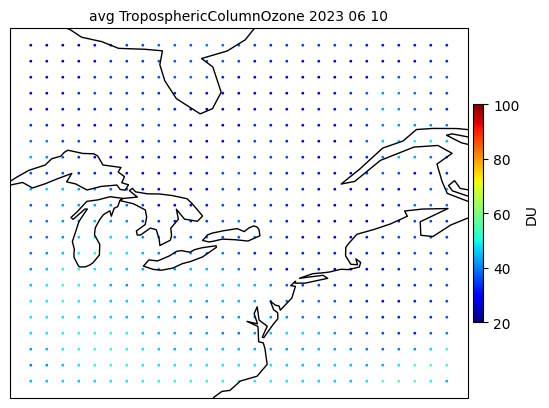

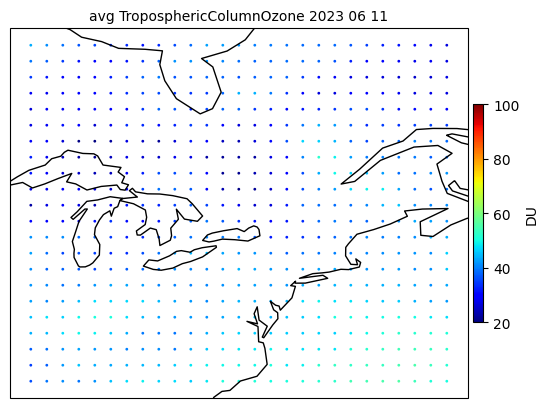

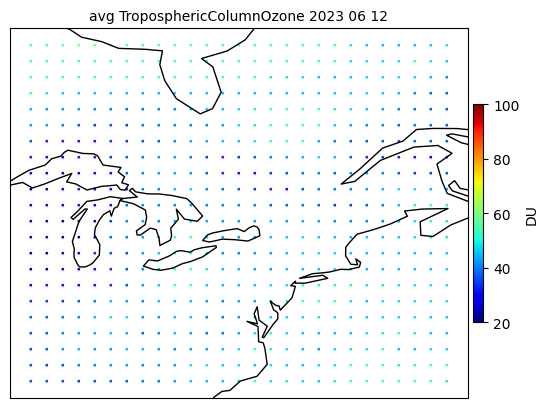

CPU times: user 13 s, sys: 1.88 s, total: 14.9 s
Wall time: 14 s


In [16]:
%%time
lon_all = np.empty([nlat_sub, nlon_sub])
for ilat in range(nlat_sub): lon_all[ilat, :] = lon_sub[:]
lat_all = np.empty([nlat_sub, nlon_sub])
for ilon in range(nlon_sub): lat_all[:, ilon] = lat_sub[:]

vmin=20. # min range for tropospheric O3
vmax=100. # max range for tropospheric O3
cbar_ticks = [20, 40, 60, 80, 100] # ticks for tropospheric column
# vmin=200. # min range for total O3
# vmax=500. # max range for total O3
# cbar_ticks = [200, 300, 400, 500, 600] # ticks for total column

for i in range(nd):
  ax = plt.axes(projection=ccrs.PlateCarree())
  ax.coastlines(resolution='110m', color='black', linewidth=1)
  ax.add_feature(cfeature.LAKES.with_scale('110m'), facecolor='none', edgecolor='black')

  im = ax.scatter(lon_all, lat_all, c=avg_O3[i, :, :], s=1, cmap=plt.cm.jet, vmin=vmin, vmax=vmax,
                  transform=ccrs.PlateCarree())
  cb = plt.colorbar(im, ticks=cbar_ticks, fraction=0.022, pad=0.01)
  cb.set_label('DU', fontsize=10)
  ax.set_title('avg '+o3_var_name+str(' %4d %2.2d %2.2d' %(year, month, days[i])), size = 10)

  plt.savefig('avg_'+o3_var_name+str('_%4d_%2.2d_ %2.2d' %(year, month, days[i]))+'.png', dpi=600)
  plt.show()
  plt.close()